In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

In [3]:
from lace.emulator_nn.network import MDNemulator_polyfit
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.test_simulation_nn import test_sim
from lace.emulator import pd_archive

# read eBOSS P1D to plot relative error bars
from lace_manager.data import data_Chabanier2019

from lace.cosmo import camb_cosmo

# read eBOSS P1D to plot relative error bars
from lace_manager.data import data_Chabanier2019

chab=data_Chabanier2019.P1D_Chabanier2019()
cosmo_fid=camb_cosmo.get_cosmology()

/data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?


In [4]:
# make pretty plots
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 24}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [5]:
def sigma68(data): return 0.5*(np.nanquantile(data,q = 0.84,axis = 0) - np.nanquantile(data,q = 0.16,axis = 0))


In [6]:
Nsim=30
emuparams = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
emulator = NNEmulator(emuparams, zmax=4.5, Nsim=30, nepochs=0, step_size=75, postprocessing='768', model_path=None, list_archives=['data_input_axes','data_input_phases'], ndeg=5)





start the training of the emulator
Training network on 11550
Emualtor trained in 3.0994415283203125e-06 seconds


In [7]:
import torch
initial_weights = emulator.emulator.state_dict()
torch.save(initial_weights,'initial_weights_v2.pt')

## LEAVE ONE OUT

f'/nfs/pic.es/user/l/lcabayol/DESI/LaCE/lace/emulator/NNmodels'

In [ ]:
fractional_errors_4=np.zeros((Nsim, 11,42))


emu_p1derrs=np.zeros((Nsim, 11,32))
emu_p1ds = np.zeros((Nsim, 11,32))
true_p1ds=np.zeros((Nsim, 11,32))

coeffs =np.zeros((Nsim, 11,7))
coeffs_err=np.zeros((Nsim, 11,7))

for simnum in range(29,Nsim):
    print('Starting sim: ', simnum) 
    emulator = NNEmulator(emuparams, zmax=4.5, Nsim=30, nepochs=100, step_size=75, kmax_Mpc=4, postprocessing='768',  drop_sim=simnum, list_archives=['data_input_axes','data_input_phases'], ndeg=5, model_path='initial_weights_v2.pt', save_path=None)

    
    truth=pd_archive.archivePD(z_max=4.5,pick_sim=simnum)
    truth.average_over_samples(flag="all")
    truth = [d for d in truth.data_av_all if d['scale_tau'] == 1] 

    fractional_error_4, emu_p1d, true_p1d, emu_p1derr = test_sim(emulator.emulator, truth, emuparams, emulator.paramLims, emulator.device, emulator.yscalings,  kmax_Mpc_test=4 ,ndeg=5)



    fractional_errors_4[simnum] = fractional_error_4

    #coeffs[simnum] = coeff
    #coeffs_err[simnum] = coeff_err

    #emu_p1ds[simnum] = emu_p1d
    #true_p1ds[simnum] = true_p1d
    #emu_p1derrs[simnum] = emu_p1derr
    

Starting sim:  29
start the training of the emulator
Training network on 11165


In [13]:
sum(p.numel() for p in emulator.emulator.parameters() if p.requires_grad)

25061

In [ ]:
25061

In [26]:
np.savetxt('fractional_errors/3_axes_lastversion/fractional_error_avaxesphases_8mpc_4mpc.txt', fractional_errors_4.reshape(30,42*11))
np.savetxt('fractional_errors/3_axes_lastversion/fractional_error_avaxesphases_8mpc_8mpc.txt', fractional_errors_8.reshape(30,85*11))



In [57]:
np.savetxt('fractional_errors/3_axes_lastversion/coefficients/coeffs_avaxesphases_5deg.txt', coeffs.reshape(30,6*11))
np.savetxt('fractional_errors/3_axes_lastversion/coefficients/coeffserr_avaxesphases_5deg.txt', coeffs_err.reshape(30,6*11))


In [17]:
fractional_errors = (np.loadtxt('fractional_errors/3_axes_lastversion/fractional_error_avaxesphases_8mpc_8mpc.txt').reshape(30,11,85))




X=1.03
idx = np.where(fractional_errors_4 > X)
loc = np.vstack((idx[0], idx[1]))

fractional_errors_4[17,10] = np.nan
fractional_errors_4[29,:] = np.nan
fractional_errors_4[22,0:4] = np.nan

In [18]:
fractional_errors = fractional_errors_4.copy()

In [19]:
truth=pd_archive.archivePD(z_max=4.5,pick_sim=1)
truth.average_over_samples(flag="all")
truth = [d for d in truth.data_av_all if d['ind_tau'] == 0] 

In [20]:
mean_ratio_rbf = np.nanmedian(fractional_errors,1)
std_ratio_rbf = sigma68(fractional_errors)

Text(0.5, 0, '$k_\\parallel$ [1/Mpc]')

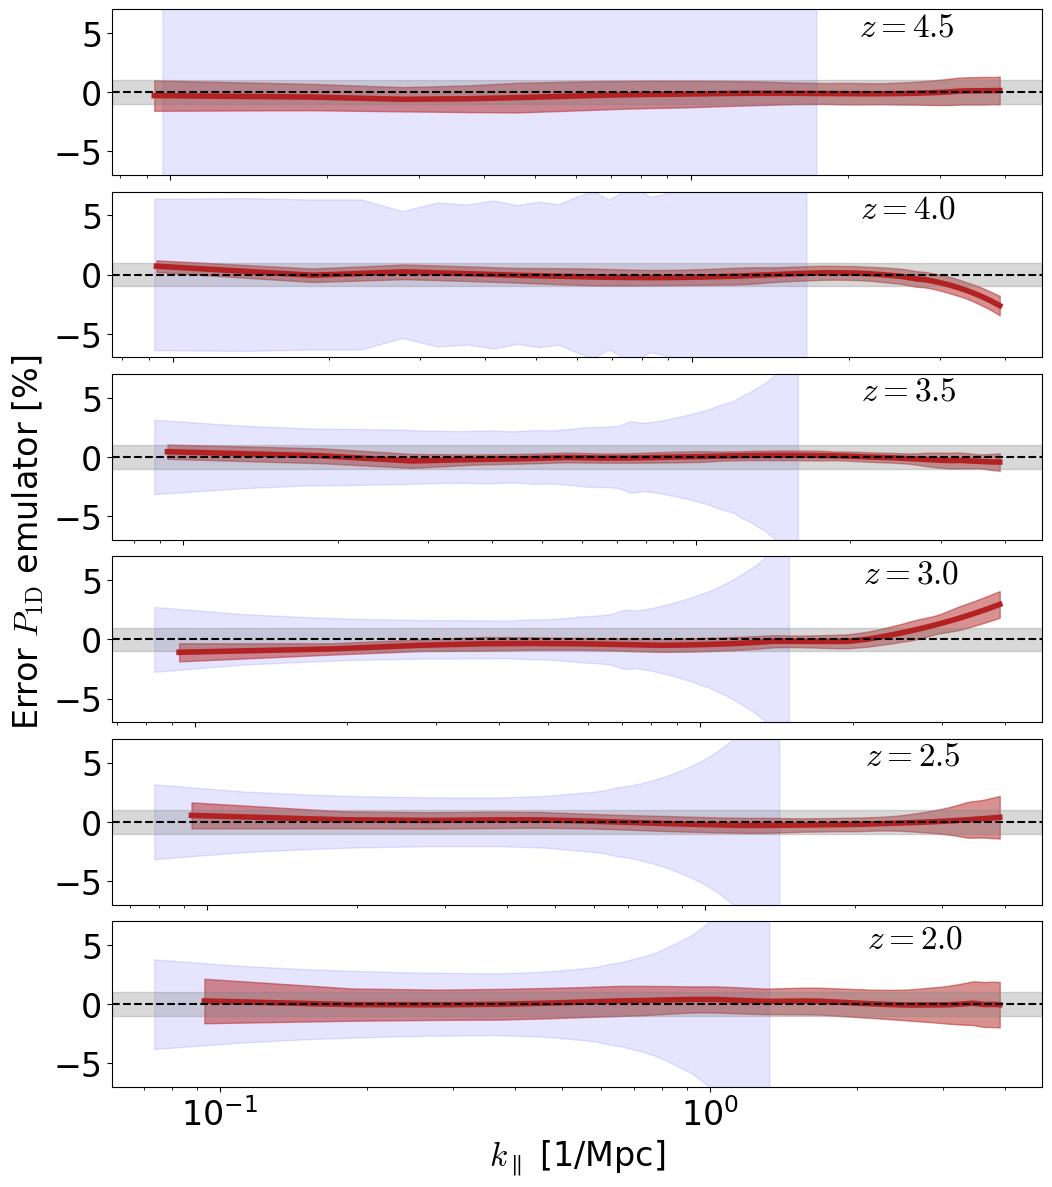

In [22]:
fig =plt.figure(figsize=[12,14])

xmin=0.068
xmax=3.2
Nk=42
Nz=11
#sim_k_Mpc =emulator.sim_k_Mpc[:Nk]
sim_k_Mpc = truth[0]['k_Mpc'][1:Nk+1]
sim_zs=np.flip(np.arange(2,4.6,0.25))


for aa in range(0,Nz,2):
    plt.subplot(int((Nz+1)/2),1,int(aa/2)+1)
    col = "firebrick"

    # Chabanier fractional error for comparison (in 1/Mpc)
    sim_z=sim_zs[aa]
    chab_index=np.abs(sim_z - chab.z).argmin()
    chab_pk=chab.get_Pk_iz(chab_index)
    chab_cov=chab.get_cov_iz(chab_index)
    chab_err=np.sqrt(np.diag(chab_cov))
    data_k=chab.k*camb_cosmo.dkms_dMpc(cosmo_fid,sim_z)
    plt.fill_between(data_k,100*chab_err/chab_pk,-100*chab_err/chab_pk,alpha=0.1,color="blue")

    # mean residual
    plt.plot(sim_k_Mpc,100*(mean_ratio_rbf[aa,:]-1),color=col,label="z=%.2f" % sim_z,linewidth=4)

    # +/- mean theoretical uncertainty
    #plt.plot(sim_k_Mpc[:20],100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(sim_k_Mpc[:20],-100*mean_error_rbf[aa,:],color="black")
    
    # +/- rms of residuals
    plt.fill_between(sim_k_Mpc,100*((mean_ratio_rbf[aa,:]+std_ratio_rbf[aa,:])-1),
            100*((mean_ratio_rbf[aa,:]-std_ratio_rbf[aa,:])-1),alpha=0.5,color=col)
    
    # 1% gray band
    plt.axhspan(-1,1,color="gray",alpha=0.3)
    plt.axhline(y=0, color='black', ls='--')

    # x-y limits
    plt.ylim(-7,7)
    #plt.xlim(0.73*sim_k_Mpc[0],1.074*sim_k_Mpc[-1])
    ax = plt.gca()
    ax.set_xscale("log")

    # add redshift label
    ax.text(2.1,4.8,r"$z=%.1f$" % sim_z)

    if aa != Nz-1:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    #if aa==int((Nz-1)/2):
    #if aa==6:
    #    plt.ylabel("Percent error")
fig.text(0.04, 0.5, r'Error $P_{\rm 1D}$ emulator [%]', va='center', rotation='vertical')
#fig.text(0.25, 0.89,r'Leave on out. Train $k_{\parallel}<4{\rm Mpc}^{-1}$ and test $k_{\parallel}<4{\rm Mpc}^{-1}$', fontsize = 16 )


plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")
#plt.savefig("one_out_mdn_gadget_8mpc.pdf", bbox_inches = 'tight',pad_inches = 0)